# 10 | Independent coding: Robust Homographies with RANSAC
**ES143 Computer Vision, Harvard University, Fall 2020**

This is an independent coding task. In it you will learn to:
* use RANSAC to estimate a homography in the presence of outliers

## Instructions:
1. Run the notebook
2. Read the notebook and edit it following the instructions
3. Post a snapshop of your final result to [padlet](https://padlet.com/zickler/ransacH) and submit `.ipynb` and `.html` versions of this notebook to [canvas](https://canvas.harvard.edu/courses/78234/assignments/422909). Submission filenames should be of the form `ransacH_lastname_firstname.ipynb` and `ransacH_lastname_firstname.html`.

In [8]:
# Import any required libraries here
import cv2                   # OpenCV
import numpy as np           # numpy
import scipy.interpolate  # interpolation, used for questions 2, 3 and 4

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

## Helper Functions

The next cell provides two main functions that you should read and understand, along with a couple of smaller helpers that you should already be familiar with.

`H = getH(X1, X2)` accepts two $N\times 2$ arrays of inhomogeneous 2D points, each with rows $(x,y)$, and returns a $3\times 3$ homography ${\bf H}$ that maps the points ${\bf x}_1\in$ `X1` as close as possible to the points ${\bf x}_2\in$ `X2`, that is ${\bf x}_2\approx{\bf H}{\bf x}_1$. It uses the (normalized) homogeneous least-squares algorithm described in Algorithm 4.2 of Hartley and Zisserman (Chapter 4, page 109) that you implemented yourself in a previous notebook.

`plotH(X1,X2,H)` generates plots that help visualize the accuracy of an estimated homography matrix. It accepts the same two $N\times 2$ arrays of 2D points as above, as well as $3\times 3$ homography ${\bf H}$. It creates two side-by-side axes, one with a scatter plot of Image 1 points ${\bf x}_1\in$ `X1`, and the other with a scatter plot of Image 2 points ${\bf x}_2\in$ `X2`. It superimposes on these the homography-mapped points: ${\bf H}{\bf x}_1\approx {\bf x}_2$ in the second axes, and ${\bf H}^{-1}{\bf x}_2\approx {\bf x}_1$ in the first axes. See examples below. If the homography is accurate then the input points and their homography-mapped counterparts should be near to each other.

Lines 79-81 of this cell are important for you to understand. They show how to efficiently compute the homography-mapped points: ${\bf H}{\bf x}_1$ for all ${\bf x}_1\in$ `X1`, and ${\bf H}^{-1}{\bf x}_2$ for all ${\bf x}_2\in$ `X2`.

In [26]:
# Convert from inhomogeneous to homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from homogeneous to inhomogeneous coordinates
def hom2in(X):
    return X[:, :2] / X[:, 2:]

# Normalizing similarity transform for HZ Algorithm 4.2
def getT(X1):
    
    assert X1.shape[1] == 2, "X1 must have 2 columns (but it has {} columns)".format(X1.shape[1])
    
    N = X1.shape[0]
    
    # Compute mean x and y
    xybar = X1.mean(axis=0, keepdims=True)
    
    # Compute the denominator of s (divided by N)
    denom = np.mean(np.sqrt(np.sum((X1 - xybar) ** 2, axis=1)))
    
    # Compute s, tx, ty
    s = np.sqrt(2) / denom
    tx = -s * xybar[0, 0]
    ty = -s * xybar[0, 1]
    
    return np.array([[s, 0, tx],
                     [0, s, ty],
                     [0, 0, 1 ]], dtype=np.float32)

# Estimate 3x3 homography from two Nx2 inhomogeneous point-sets
def getH(X1, X2):

    assert np.all(X1.shape == X2.shape), "X1 and X2 must have the same shape"
    assert X1.shape[1] == 2, "X1 and X2 must have 2 columns (but they have {} columns)".format(X1.shape[1])
    
    N = X1.shape[0]
    
    # Normalizing similarity transform for both sets of points
    T1 = getT(X1)
    T2 = getT(X2)
        
    # Get homogeneous points and apply T matrix (note that X*T' = (T*X')', where ' denotes the transpose operator)
    X1h = in2hom(X1).dot(T1.transpose())
    X2h = in2hom(X2).dot(T2.transpose())
    
    # Construct A matrix of the homogeneous linear system.        
    A11 = np.zeros((N, 3), dtype=np.float32)
    A12 =  X2h[:, 2:]  * X1h
    A13 = -X2h[:, 1:2] * X1h
    A21 = -A13
    A22 = -X2h[:, :1]  * X1h
    A23 = A11
    
    A = np.block([[A11, A12, A13],
                  [A21, A22, A23]])
    
    # Compute SVD and take last column of V (note that numpy.linalg.svd() returns V transpose)
    _, _, VT = np.linalg.svd(A)
    
    h = VT[-1, :]

    # Get H' by reshaping h
    Hp = np.reshape(h, (3, 3))
        
    # Undo the normalizing similarity transforms
    invT2Hp, _, _, _ = np.linalg.lstsq(T2, Hp, rcond=None)
    H = invT2Hp.dot(T1)
    
    return H

# Display input points X1, X2 and homography-mapped points H @ X1, inv(H) @ X2
def plotH(X1,X2,H):
    
    # Map points using the estimated homography:
    #    map X1 via H @ X1
    #    map X2 via inv(H) @ X2
    # Note that X*H' = (T*H')', where ' denotes the transpose operator.
    # Also, as usual, use numpy.linalg.lstsq() instead of inv().
    X1_mapped = hom2in(in2hom(X1).dot( H.T ) )
    X2_mapped, _, _, _ = np.linalg.lstsq(H, in2hom(X2).transpose(), rcond=None)
    X2_mapped = hom2in(X2_mapped.transpose())

    # create figure to verify results
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))

    # plot input points
    ax1.plot(X1[:, 0], X1[:, 1], 'b.', markersize=12, label = 'X1')
    ax2.plot(X2[:, 0], X2[:, 1], 'b.', markersize=12, label = 'X2')

    # plot points mapped by estimated homography and its inverse
    ax1.plot(X2_mapped[:, 0], X2_mapped[:, 1], 'r.', markersize=6,label = 'H_inv*X2')
    ax2.plot(X1_mapped[:, 0], X1_mapped[:, 1], 'r.', markersize=6, label = 'H*X1')

    ax1.legend()
    ax2.legend()

    # make axes "image-like", with origin (0,0) in the top-left corner
    ax1.set_aspect(aspect=1)
    ax1.set_xlim([-IMSIZE, IMSIZE])
    ax1.set_ylim([-IMSIZE, IMSIZE])
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()

    ax2.set_aspect(aspect=1)
    ax2.set_xlim([-IMSIZE, IMSIZE])
    ax2.set_ylim([-IMSIZE, IMSIZE])
    ax2.invert_yaxis()
    ax2.xaxis.tick_top()
    
    return fig, ax1, ax2

## Define and visualize the test data

The next cell generates a random set of test data, including a "true" homography matrix `TRUE_H` that your RANSAC code will attempt to estimate. There are three main variables defined in this cell that you will use later in the notebook:

`X1in`: $N\times 2$ array of inhomogeneous 2D points in Image 1, with rows $(x,y)$
`X2in`: $N\times 2$ array of inhomogeneous 2D points in Image 2, with rows $(x,y)$
`TRUE_H`: Homoography matrix that is to obe estimated

The dataset is generated with no noise, so that ${\bf x}_2={\bf H}_\text{TRUE}{\bf x}_1$ for all corresponding rows of `X1in` and `X2in`.

This means that if we estimate the homography using `H = getH(X1in,X2in)`, then the estimated homography `H` is equal to the true homography `TRUE_H` up to scale. This is evident in the plot that follows the cell, where the homography-mapped points (small red dots) using estimated homography `H` are exactly coincident with their corresponding input points (large blue dots).  


(<Figure size 1080x720 with 2 Axes>, <AxesSubplot:>, <AxesSubplot:>)

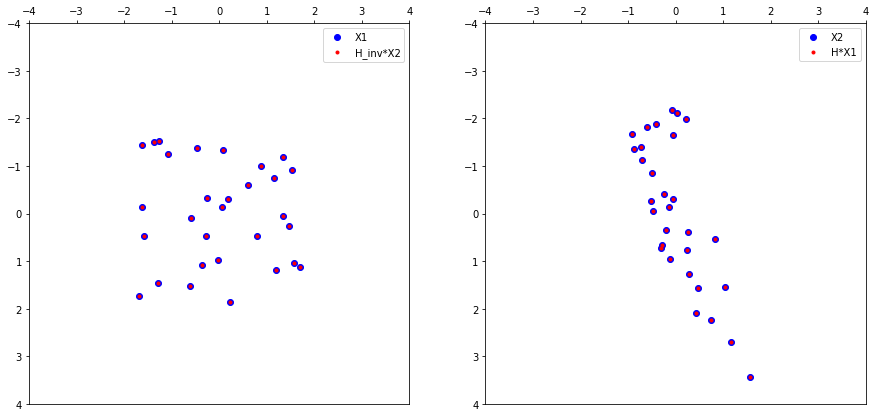

In [27]:
NUM_INLIERS = 30   #  number of inlier correspondences (default = 30)
IMSIZE = 4         # "image size": point coordinates are in range [-IMSIZE, IMSIZE]

# generate a random 3x3 homography
H = np.reshape(np.random.rand(9),(3,3))

# generate random "inlier" points in Image 1:
#   NUM_INLIERS x 2 array with rows (x,y)
X1in = np.random.rand(NUM_INLIERS, 2)

# corresponding "inlier" points in Image 2.
#   (note that X*H' = (H*X')' where ' is transpose operator)
X2in = hom2in( in2hom(X1in).dot( H.T ) )

# Transform the point-sets to have coordinates in range [-IMSIZE, IMSIZE]
T1 = getT(X1in)
T2 = getT(X2in)
X1in = hom2in(in2hom(X1in).dot(T1.T))
X2in = hom2in(in2hom(X2in).dot(T2.T))

# Adjust the initial random homography to incorporate these transformations.
# This is the homography that is supposed to be estimated in subsequent cells.
TRUE_H = T2 @ H @ np.linalg.inv(T1)

# Estimate homography
H_est = getH(X1in, X2in)

# visualize results
plotH(X1in,X2in,H_est)

## Introduce outliers, and feel the pain

The next cell adds _just one_ outlier to this dataset, meaning one additional point in Image 1 and one additional point in Image 2 that are not related by homography `TRUE_H` and are falsely assumed to correspond. (You are welcome to increase the number of outliers by changing the value of `NUM_OUTLIERS`.)

Now, when the same `getH(X1, X2)` function is used to estimate the homography using this new dataset with outliers, the results are not good. Because `getH()` minimizes error in the least-squares sense, it is badly affected by the outliers. As a result, the homography-mapped points (small red dots) are all displaced from where we want them to be (large blue dots).

(<Figure size 1080x720 with 2 Axes>, <AxesSubplot:>, <AxesSubplot:>)

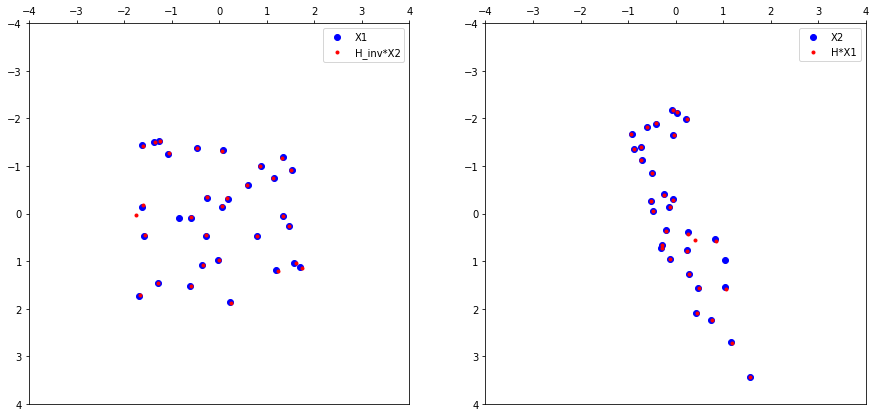

In [28]:
NUM_OUTLIERS = 1

# outliers are random points in Image 1 and unrelated, random points in Image 2
X1out = IMSIZE*(np.random.rand(NUM_OUTLIERS, 2) - 0.5)
X2out = IMSIZE*(np.random.rand(NUM_OUTLIERS, 2) - 0.5)

# combine outliers with inliers
X1 = np.vstack((X1in,X1out))
X2 = np.vstack((X2in,X2out))

# now estimate the homography again and visualize the results
H_est2 = getH(X1, X2)

plotH(X1,X2,H_est2)

## Enter RANSAC (YOUR WORK HERE)
The solution to your outlier problem is RANSAC. As discussed in Class Session A on Tu 11/10, the idea is to randomly sample a subset of four correspondences, compute a potential homography ${\bf H}_i$ from this sample, and then count the number of other correspondences that agree with (i.e., are in the "consensus set" of) this potential homography. You repeat this many times (a loop with `num_iters` iterations), keeping track of which consensus set is the largest. At the end, you fit a final homography to the correspondences that are in the largest consensus set, ignoring the other correspondences as "outliers".

Your task is to write code that replaces line 19. This is the part of the loop that computes the consensus set by assessing how well each correspondence `X1[j,:]`, `X2[j,:]` "agrees" with a potential homography ${\bf H}_i$.

In particular, you should replace line 19 with code that properly computes the variable  `distance`, which is meant to be a vector of length `N` (number of points) such that `distance[j]` is the symmetric transfer error between point `X1[j,:]` and point `X2[j,:]` under homography ${\bf H}_i$. (See Hartley and Zisserman Equation 4.6 on page 94, and see the lecture slides for Class Session A on Tu 11/10.)

In [29]:
print(X1.shape)
print(X2.shape)

(31, 2)
(31, 2)


In [52]:
def getH_ransac(X1, X2, threshold, num_iters):

    assert X1.shape[1] == 2, "X1 must have 2 columns (but it has {} columns)".format(X1.shape[1])
    assert X1.shape[0] == X2.shape[0], "X1 and X2 must have the same number of rows"
    
    N = X1.shape[0] # number of correspondences
    
    best_consensus = np.zeros((1,))  # Initialize as zeros so its sum is zero
    for i in range(num_iters):
        
        # Randomly select 4 correspondences
        ind = np.random.choice(np.arange(N), size=4, replace=False)
        
        # Get homography between the 4 point pairs
        H = getH(X1[ind, :], X2[ind, :])
        
        ### YOUR CODE HERE: Replace the following line with your code
        ###   (as it is, this line sets all distances to be less than threshold
        ###    so all correspondences are always in consensus set)
        Hinv = np.linalg.inv(H)
        HX1_rand = hom2in((H @ in2hom(X1).T).T)
        HinvX2_rand = hom2in((Hinv @ in2hom(X2).T).T)
#         print(HX1_rand.shape)
#         print(HinvX2_rand.shape)
#         print(X2.shape)
#         print(X1.shape)
#         print(X1in.shape)
        distances= np.sqrt(np.sum((X2 - HX1_rand)**2, axis=1)) + np.sqrt(np.sum((X1 - HinvX2_rand)**2,axis=1))
#         print(distances)
        
        # Find consensus set: Produce a binary vector of length N, where distance[j]==1
        # indicates that the j-th correspondence X1[j,:] <-> X2[j,:] is in
        # the consensus set
        consensus = (distances < threshold)
        print("consensus:", consensus)

        # If size of consensus set is largest so far, use it
        if sum(consensus) > sum(best_consensus):
            best_consensus = consensus

    # Use the largest consensus set to get final least-squares estimate of homography
    return getH(X1[best_consensus, :], X2[best_consensus, :])

In [54]:
getH_ransac(X1,X2, 0.1, 100)

consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]
consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]
consensus: [False False False False False False False False False False  True False
 False False False  True False  True False False False False False False
 False False False False False False  True]
consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]
consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True Fa

array([[ 0.24714261, -0.19867903,  0.03383116],
       [ 0.18107551, -0.73269569, -0.02953313],
       [-0.092556  , -0.03309891, -0.56403633]])

## Use this to test your code
When your code is correct, you should see the homography-mapped points (small red dots) be exactly coicident with the input points (large blue dots), except for a small number of outliers. You can test the resilience of the algorithm by experimenting with the RANSAC parameters (`THRESHOLD` and `NUM_ITERS`) and the number of outliers (`NUM_OUTLIERS`).

When you are done, post a snapshot of your results to [padlet](https://padlet.com/zickler/ransacH), including your name in the title of your post, and a description of the values (`THRESHOLD`, `NUM_ITERS`, `NUM_OUTLIERS`) that you used.

consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]
consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]
consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]
consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]
consensus: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True Fa

(<Figure size 1080x720 with 2 Axes>, <AxesSubplot:>, <AxesSubplot:>)

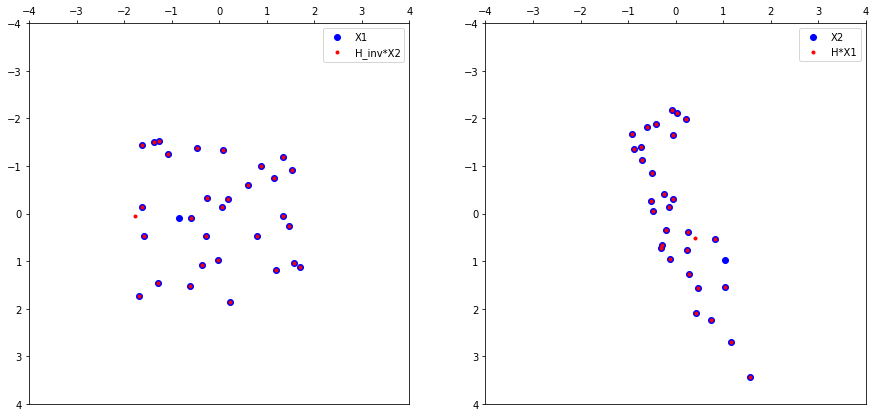

In [55]:
# Define RANSAC parameters
THRESHOLD = 0.1
NUM_ITERS = 100

# RANSAC-estimate of homography
H_est = getH_ransac(X1, X2, THRESHOLD, NUM_ITERS)

# visualize results
plotH(X1,X2,H_est)